## Notebook Overview

This notebook is designed to perform data preprocessing and Exploratory Data Analysis (EDA) for three distinct tasks related to rice leaf image classification. The primary goal is to prepare the datasets for each task, including cleaning, standardizing images, organizing them according to task-specific criteria (label, variety, age), and finally, splitting them into training and validation sets. The processed datasets for each task will be zipped for easy download and subsequent use in model training.

## Environment Setup: Installing Dependencies and Libraries

### Purpose
This initial section focuses on setting up the Python environment by installing specific versions of essential libraries. This ensures the reproducibility and compatibility of the code across different execution environments.

### Key Libraries to be Installed:
- **scikit-learn (sklearn)**: A fundamental library for machine learning in Python, offering a wide range of tools for tasks such as classification, regression, clustering, dimensionality reduction, model selection, and data preprocessing.
- **imbalanced-learn (imblearn)**: A specialized package that provides techniques for handling imbalanced datasets, which are common in classification problems. It includes methods for over-sampling, under-sampling, and combination sampling.

In [1]:
pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import the libraries to check their versions
import sklearn
import imblearn

# Print the version of scikit-learn
print("scikit-learn version:", sklearn.__version__)
# Print the version of imbalanced-learn
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.3.2
imbalanced-learn version: 0.11.0


### Import Necessary Libraries

This cell imports all other Python libraries and modules required for the various data processing, manipulation, visualization, and file operation tasks performed throughout this notebook.

- **Purpose**: To load all required modules into the Python environment, making them readily available for use in subsequent cells.
- **Key Libraries Imported**:
    - `gdown`: For downloading files from Google Drive.
    - `csv`, `os`, `shutil`, `zipfile`, `pathlib.Path`: For file system operations, CSV handling, and archive management.
    - `pandas (pd)`: Essential for data manipulation and analysis, primarily using its DataFrame structures.
    - `hashlib`: For generating MD5 hashes, used here to check for file integrity and identify duplicate images.
    - `tqdm`: For creating progress bars, which provide visual feedback for long-running operations.
    - `cv2 (OpenCV)`: A comprehensive library for computer vision tasks, including image processing and manipulation.
    - `numpy (np)`: The fundamental package for numerical computation in Python, widely used for array and matrix operations.
    - `PIL (Pillow)`: The Python Imaging Library, used for opening, manipulating, and saving many different image file formats.
    - `matplotlib.pyplot (plt)`: A widely used plotting library for creating static, interactive, and animated visualizations.
    - `random`, `math`: Standard Python libraries for random number generation and mathematical functions, respectively.
    - `sklearn.model_selection.train_test_split`: A function from scikit-learn for splitting datasets into training and testing (or validation) subsets.
    - `imblearn.under_sampling.TomekLinks`, `imblearn.over_sampling.SMOTE`: Techniques from imbalanced-learn for addressing class imbalance in datasets.
    - `collections.Counter`: For counting hashable objects, useful for determining class distributions.
    - `tensorflow.keras.preprocessing.image.ImageDataGenerator`: A Keras utility for real-time data augmentation and loading image data for deep learning models.

In [ ]:
# For downloading files from Google Drive
import gdown 
# For working with CSV files
import csv 
# For interacting with the operating system (file paths, directories)
import os 
# For high-level file operations (copying, removing directories)
import shutil 
# For working with ZIP archives
import zipfile 
# For data manipulation and analysis (DataFrames)
import pandas as pd 
# For generating MD5 hashes (checking for duplicate files)
import hashlib 
# For displaying progress bars
from tqdm import tqdm 
# For image processing (OpenCV)
import cv2 
# For numerical operations (arrays, matrices)
import numpy as np 
# For image manipulation (Python Imaging Library)
from PIL import Image 
# For object-oriented filesystem paths
from pathlib import Path 
# For plotting graphs and visualizations
import matplotlib.pyplot as plt 
# For generating random numbers and choices
import random 
# For mathematical functions
import math 
# For splitting data into training and testing sets
from sklearn.model_selection import train_test_split 
# For under-sampling techniques (Tomek Links) - if needed for imbalance
from imblearn.under_sampling import TomekLinks 
# For over-sampling techniques (SMOTE) - if needed for imbalance
from imblearn.over_sampling import SMOTE 
# For counting occurrences of items in a collection (e.g., class distribution)
from collections import Counter 
# For real-time data augmentation and loading images in Keras/TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-16 05:32:42.158921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747373562.467418      85 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747373562.550314      85 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Main Dataset Acquisition

This section outlines the procedures for downloading and extracting the primary dataset required for the project. The dataset, consisting of training images and an associated metadata file, is sourced from Google Drive.

In [ ]:
# Google Drive file ID for the main training images zip file
file_id = "1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e"
file_name = "train_images.zip"
folder_name = "/kaggle/working/original_data"

# Delete the folder if it already exists to prevent errors from previous runs or outdated files
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)

# Create the folder to store the downloaded data
os.makedirs(folder_name, exist_ok=True) # exist_ok=True prevents error if folder is created by another process concurrently
file_path = os.path.join(folder_name, file_name)

# Download the file from Google Drive using gdown
print(f"Downloading {file_name} from Google Drive...")
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)

print(f"Downloaded: {file_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e
From (redirected): https://drive.google.com/uc?id=1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e&confirm=t&uuid=8a5e6e02-5725-46fd-8fce-baa3f149386b
To: /kaggle/working/original_data/train_images.zip
100%|██████████| 820M/820M [00:05<00:00, 144MB/s]  

Downloaded: /kaggle/working/original_data/train_images.zip


### Extract Main Training Images

Following the download, this cell extracts the contents of the `train_images.zip` file. The images are typically organized within subdirectories in the archive, which will be preserved upon extraction.

In [ ]:
# Path to the downloaded zip file
zip_file_path = "/kaggle/working/original_data/train_images.zip"
# Directory where the contents will be extracted
extraction_path = "/kaggle/working/original_data"

print(f"Extracting {zip_file_path} to {extraction_path}...")
# Open the zip file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_path)

print("Extraction complete.")

Extraction complete.


### Download Metadata File

This cell downloads the metadata file (`meta_train.csv`) from Google Drive. This CSV file contains essential information associated with each image in the main training dataset, such as image IDs and corresponding labels (e.g., disease type, variety, age).

- **Purpose**: To obtain the structured metadata which provides labels and other attributes for the training images.
- **Key Components**:
    - `file_id`: The unique Google Drive identifier for the `meta_train.csv` file.
    - `file_name`: The name of the CSV file ("meta_train.csv").
    - `folder_name`: The local directory (`/kaggle/working/original_data/`) where the CSV file will be saved.
    - `gdown.download()`: Downloads the file from the specified Google Drive URL.
- **Inputs**:
    - Google Drive File ID for `meta_train.csv`.
- **Outputs**:
    - `meta_train.csv` is downloaded to the `/kaggle/working/original_data/` directory.
    - A confirmation message with the download path is printed.
- **Why it Matters**: The metadata file is crucial for supervised learning. It links each image to its ground truth label and potentially other relevant features, which are necessary for training classification models and for performing stratified analyses or splits.

In [ ]:
# Google Drive file ID for the metadata CSV file
file_id = "1HHhdIPkl4hrYer0udqFwg4U1SgwPRbkz"
file_name = "meta_train.csv"
folder_name = "/kaggle/working/original_data" # Should already exist

file_path = os.path.join(folder_name, file_name)

print(f"Downloading {file_name} from Google Drive...")
# Download the metadata file from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)

print(f"Downloaded: {file_path}")

Downloading...
From: https://drive.google.com/uc?id=1HHhdIPkl4hrYer0udqFwg4U1SgwPRbkz
To: /kaggle/working/original_data/meta_train.csv
100%|██████████| 335k/335k [00:00<00:00, 48.5MB/s]

Downloaded: /kaggle/working/original_data/meta_train.csv


# Data Cleaning

This section focuses on the initial cleaning of the dataset. The first step involves inspecting the primary metadata file for any missing values, which could impact subsequent processing or model training.

### Check for Missing Values in Metadata

This cell reads the downloaded `meta_train.csv` file into a pandas DataFrame. It then uses the `.isnull().sum()` method to count the number of missing (NaN or null) values in each column of the DataFrame.

- **Purpose**: To identify if there are any missing entries in the metadata. Missing data can lead to errors during data processing, introduce bias, or require specific handling strategies (e.g., imputation, removal of records).
- **Why it Matters**: Identifying missing metadata is a critical first step in data cleaning. If significant missing data were found, strategies such as removing the affected rows/columns or imputing the missing values would need to be considered. In this case, the expectation is to find no missing values for critical fields.

In [ ]:
# Define the path to the metadata CSV file
metadata_file_path = '/kaggle/working/original_data/meta_train.csv'

# Load the main metadata CSV file into a pandas DataFrame
MetaImagesDataframe = pd.read_csv(metadata_file_path)

# Display the sum of missing values for each column in the DataFrame
print(f"Checking for missing values in {metadata_file_path}:")
print(MetaImagesDataframe.isnull().sum())

image_id    0
label       0
variety     0
age         0
dtype: int64


## Placing All Images into a Standardized Folder

This subsection describes the process of consolidating all images from the main dataset's potentially nested directory structure into a single, flat directory. This simplifies subsequent operations like duplicate checking and batch processing.

### Define Standardized Directory Paths

In [ ]:
# Define the path for the directory where all images will be consolidated and standardized
standardize_dir = "/kaggle/working/standardized_images"
# Define the path to the main dataset images (extracted from train_images.zip)
main_dataset_path = "/kaggle/working/original_data/train_images" # This is the folder created after extracting train_images.zip

### Consolidate Main Dataset Images

This cell copies all image files from the nested subdirectories of the `main_dataset_path` (e.g., class-specific folders) into the single `standardize_dir`. This creates a flat directory of all images from the main dataset.

In [ ]:
# Delete the standardized directory if it already exists to ensure a fresh start
if os.path.exists(standardize_dir):
    print(f"Removing existing standardized directory: {standardize_dir}")
    shutil.rmtree(standardize_dir)
    
# Create the standardized directory
print(f"Creating standardized directory: {standardize_dir}")
os.makedirs(standardize_dir, exist_ok=True)

image_copy_count = 0
# Check if the main dataset path exists
if os.path.isdir(main_dataset_path):
    print(f"Consolidating images from {main_dataset_path}...")
    # Iterate through each category (subdirectory) in the main dataset path
    for category_folder_name in tqdm(os.listdir(main_dataset_path), desc="Processing categories"):
        category_path = os.path.join(main_dataset_path, category_folder_name)
        # Check if the item is a directory (i.e., a category folder)
        if os.path.isdir(category_path):
            # Iterate through each image file in the category folder
            for img_file_name in os.listdir(category_path):
                img_src_path = os.path.join(category_path, img_file_name)
                # Check if the item is a file and has a common image extension
                if os.path.isfile(img_src_path) and img_file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_dest_path = os.path.join(standardize_dir, img_file_name)
                    # Copy the image file to the standardized directory
                    shutil.copy2(img_src_path, img_dest_path)
                    image_copy_count += 1
    print(f"Copying main dataset images to standardized folder completed. Total images copied: {image_copy_count}")
else:
    print(f"Error: Main dataset path not found: {main_dataset_path}")

### Remove Duplicate and Corrupted Images from Standardized Folder

This cell defines and applies functions to identify and remove duplicate images based on their content (MD5 hash) and to remove any corrupted image files found within the `standardize_dir`.

- **Purpose**: To ensure data quality and integrity by eliminating redundant data (exact duplicates) and problematic files (corrupted images) that could interfere with subsequent processing or model training.
- **Key Components**:
    - `compute_md5(file_path)`: 
        - Takes a file path as input.
        - Opens the file in binary read mode (`'rb'`).
        - Reads the file's content and computes its MD5 hash using `hashlib.md5()`.
        - Returns the hexadecimal representation of the hash.
        - Includes error handling: If an exception occurs during file reading (e.g., for a corrupted image), it prints a warning, removes the problematic file using `os.remove()`, and returns `None`.
- **Why it Matters**: Removing duplicates prevents the model from being biased towards over-represented samples and ensures that evaluation metrics are more reliable. Removing corrupted files prevents errors in later data loading and processing stages.

In [ ]:
# Function to compute MD5 hash of a file
def compute_md5(file_path):
    try:
        # Open file in binary read mode
        with open(file_path, 'rb') as f:
            # Read the file content and compute MD5 hash
            file_hash = hashlib.md5()
            while chunk := f.read(8192): # Read in chunks for large files
                file_hash.update(chunk)
            return file_hash.hexdigest()
    except Exception as e:
        # If an error occurs (e.g., corrupted file), print a warning and attempt to remove the file
        print(f"⚠️ Error computing hash for {file_path}: {e}. Attempting to remove.")
        try:
            os.remove(file_path)
            print(f"Successfully removed corrupted file: {file_path}")
        except OSError as oe:
            print(f"Error removing corrupted file {file_path}: {oe}")
        return None

# Function to remove duplicate files in a given folder based on MD5 hash
def remove_duplicates_in_folder(folder_path):
    seen_hashes = set() # Set to store hashes of files already processed
    duplicates_removed_count = 0 # Counter for removed duplicate files
    corrupted_files_handled = 0 # Counter for files that were corrupted and handled (removed)
    files_to_check = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Starting duplicate check for {len(files_to_check)} image files in {folder_path}...")
    # Iterate through all image files in the folder with a progress bar
    for filename in tqdm(files_to_check, desc=f'Checking {os.path.basename(folder_path)} for duplicates'):
        file_path = os.path.join(folder_path, filename)
        
        file_hash = compute_md5(file_path)

        if file_hash is None: # Indicates file was corrupted and handled by compute_md5
            corrupted_files_handled += 1
            continue 

        # If hash is already seen, it's a duplicate; remove it
        if file_hash in seen_hashes:
            try:
                os.remove(file_path)
                duplicates_removed_count += 1
            except OSError as e:
                print(f"Error removing duplicate file {file_path}: {e}")
        else:
            # If hash is new, add it to the set of seen hashes
            seen_hashes.add(file_hash)

    print(f'Duplicate check completed for {folder_path}.')
    print(f'Removed {duplicates_removed_count} duplicate images.')
    if corrupted_files_handled > 0:
        print(f'Handled (removed) {corrupted_files_handled} corrupted files during hash computation.')

# Check if the standardized directory exists and then remove duplicates
if os.path.isdir(standardize_dir):
    remove_duplicates_in_folder(standardize_dir)
else:
    print(f"Error: Standardized directory not found: {standardize_dir}. Skipping duplicate removal.")

Checking /kaggle/working/original_data/train_images/tungro: 100%|██████████| 1088/1088 [00:00<00:00, 4690.58it/s]


Removed 8 duplicates in /kaggle/working/original_data/train_images/tungro


Checking /kaggle/working/original_data/train_images/bacterial_panicle_blight: 100%|██████████| 337/337 [00:00<00:00, 5628.35it/s]


Removed 1 duplicates in /kaggle/working/original_data/train_images/bacterial_panicle_blight


Checking /kaggle/working/original_data/train_images/downy_mildew: 100%|██████████| 620/620 [00:00<00:00, 5004.31it/s]


Removed 2 duplicates in /kaggle/working/original_data/train_images/downy_mildew


Checking /kaggle/working/original_data/train_images/brown_spot: 100%|██████████| 965/965 [00:00<00:00, 4900.55it/s]


Removed 12 duplicates in /kaggle/working/original_data/train_images/brown_spot


Checking /kaggle/working/original_data/train_images/dead_heart: 100%|██████████| 1442/1442 [00:00<00:00, 5240.39it/s]


Removed 13 duplicates in /kaggle/working/original_data/train_images/dead_heart


Checking /kaggle/working/original_data/train_images/bacterial_leaf_streak: 100%|██████████| 380/380 [00:00<00:00, 4570.60it/s]


Removed 0 duplicates in /kaggle/working/original_data/train_images/bacterial_leaf_streak


Checking /kaggle/working/original_data/train_images/normal: 100%|██████████| 1764/1764 [00:00<00:00, 4796.36it/s]


Removed 15 duplicates in /kaggle/working/original_data/train_images/normal


Checking /kaggle/working/original_data/train_images/bacterial_leaf_blight: 100%|██████████| 479/479 [00:00<00:00, 4678.68it/s]


Removed 8 duplicates in /kaggle/working/original_data/train_images/bacterial_leaf_blight


Checking /kaggle/working/original_data/train_images/hispa: 100%|██████████| 1594/1594 [00:00<00:00, 5348.26it/s]


Removed 5 duplicates in /kaggle/working/original_data/train_images/hispa


Checking /kaggle/working/original_data/train_images/blast: 100%|██████████| 1738/1738 [00:00<00:00, 5217.85it/s]

Removed 10 duplicates in /kaggle/working/original_data/train_images/blast


## Data Pre-processing: Image Standardization

This section focuses on standardizing the visual characteristics of the images in the `standardize_dir`. Uniformity in image properties like size, color mode, and pixel value range is crucial for effective model training.

### Standardize Images (Resize, Convert, Normalize)

This cell defines and applies a function `standardize_images_in_folder` to process each image in the `standardize_dir`. The standardization process includes:
1.  Converting all images to RGB color mode.
2.  Resizing all images to a fixed `target_size` (e.g., 224x224 pixels).
3.  Applying Gaussian blur for minor noise reduction.
4.  Normalizing pixel values to the [0, 1] range.
Optionally, it includes a step to identify and skip (or remove) very low-contrast images.

- **Purpose**: To transform all images into a consistent format and numerical range, which is essential for stable and efficient training of deep learning models.
- **Key Components**:
    - `target_size = (224, 224)`: Defines the uniform dimensions to which all images will be resized.
    - `standardize_images_in_folder(folder_path)`:
        - Iterates through each image file in the `folder_path` using `tqdm` for a progress bar.
        - `Image.open(file_path).convert('RGB')`: Opens an image using Pillow and ensures it is in the RGB color format. This handles images that might be grayscale, RGBA, or in other modes.
        - `img.resize(target_size, Image.Resampling.LANCZOS)`: Resizes the image to `target_size` using the LANCZOS resampling filter, which is generally good for downscaling quality.
        - `img_np = np.array(img)`: Converts the Pillow Image object to a NumPy array for numerical processing.
        - `cv2.GaussianBlur(img_np, (3, 3), 0)`: Applies a gentle Gaussian blur with a 3x3 kernel. This can help reduce minor noise and irrelevant high-frequency details.
        - `img_np_normalized = img_np_blurred / 255.0`: Normalizes the pixel values from the typical 0-255 range to the 0-1 range by dividing by 255.0.
        - Low-contrast check (optional): `if img_np_normalized.std() < 0.01:` - If the standard deviation of the normalized pixel values is very low, the image might lack significant features. Such images can be skipped or removed.
        - `cleaned_img_uint8 = (img_np_normalized * 255).astype(np.uint8)`: Converts the normalized (0-1 range) image back to the 0-255 uint8 format if needed for saving or certain types of display, though for model input, the normalized form is usually preferred.
        - `cleaned_img_pil = Image.fromarray(cleaned_img_uint8)`: Converts the processed NumPy array back to a Pillow Image object.
        - `cleaned_img_pil.save(file_path)`: Saves the standardized image, overwriting the original file in the `standardize_dir`.
    - Error handling: Includes a `try-except` block to catch issues during image opening or processing (e.g., for residual corrupted files), print an error, and optionally remove the problematic file.
- **Why it Matters**: Neural networks expect input data to be in a consistent shape and format. Resizing ensures all input tensors have the same dimensions. RGB conversion ensures consistent color channels. Normalization helps in stabilizing the learning process and can speed up convergence. Noise reduction can help the model focus on more salient features.

In [11]:
standardize_dir = Path("/kaggle/working/standardized_images")

In [ ]:
# Define the target size for image standardization (width, height)
target_size = (224, 224) # Common size for many pre-trained models

# Function to standardize images within a given folder
def standardize_images_in_folder(folder_path):
    processed_count = 0
    error_count = 0
    low_contrast_skipped = 0
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Starting standardization for {len(image_files)} images in {folder_path}...")
    # Iterate through all files in the folder with a progress bar
    for filename in tqdm(image_files, desc=f'Standardizing images in {os.path.basename(folder_path)}'):
        file_path = os.path.join(folder_path, filename)
            
        try:
            # Load image using PIL and convert to RGB format
            img = Image.open(file_path).convert('RGB')

            # Resize image to the target standard size using LANCZOS for quality
            img = img.resize(target_size, Image.Resampling.LANCZOS)

            # Convert PIL Image to NumPy array for OpenCV processing
            img_np = np.array(img)

            # Apply Gaussian blur for noise reduction (kernel size 3x3, std dev 0)
            img_np_blurred = cv2.GaussianBlur(img_np, (3, 3), 0)

            # Normalize pixel values to the range [0, 1] for potential model input or checks
            img_np_normalized = img_np_blurred / 255.0

            # Optional: Check for and skip low-contrast images
            if img_np_normalized.std() < 0.01: # Threshold for low contrast
                # print(f"Skipped low-contrast image: {filename}")
                # os.remove(file_path) # Optionally remove if desired
                low_contrast_skipped += 1
                continue # Skip saving this image

            # For saving, ensure the image is in uint8 format (0-255 range)
            # If normalization was purely for checks, we can use img_np_blurred directly
            # If the model expects 0-1, this step would be different or done in data loader
            # Here, we save the blurred image (still in 0-255 range if not explicitly normalized for saving)
            cleaned_img_pil = Image.fromarray(img_np_blurred) # img_np_blurred is already uint8
            
            # Save the cleaned and standardized image, overwriting the original file
            cleaned_img_pil.save(file_path)
            processed_count += 1

        except Exception as e:
            # Print an error message if processing fails for any image
            print(f"Error processing {filename}: {e}")
            error_count += 1
            # Optionally remove corrupted files that cannot be processed
            # try:
            #     os.remove(file_path)
            #     print(f"Removed problematic file: {file_path}")
            # except OSError as oe:
            #     print(f"Error removing problematic file {file_path}: {oe}")

    print(f"Image standardization process completed for {folder_path}.")
    print(f"Successfully processed and saved: {processed_count} images.")
    if low_contrast_skipped > 0:
        print(f"Skipped {low_contrast_skipped} low-contrast images.")
    if error_count > 0:
        print(f"Encountered errors with {error_count} images.")

# Check if the standardized directory exists and then standardize images
if os.path.isdir(standardize_dir):
    standardize_images_in_folder(standardize_dir)
else:
    print(f"Error: Standardized directory not found: {standardize_dir}. Skipping image standardization.")

# Exploratory Data Analysis (EDA)

This section begins the exploratory data analysis by first confirming the total number of images remaining after all cleaning, consolidation, and standardization steps.

In [40]:
standardize_dir = "/kaggle/working/standardized_images"

### Total Image Count Post-Processing


In [39]:
print(f'Total images: {len(os.listdir(standardize_dir))}')

Total images: 10333


In [ ]:
output_dir = Path("/kaggle/working/output_images")

# Delete the folder if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.mkdir(output_dir)

Function for spliting the dataset

In [16]:
def split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2):
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print(f"No images found in {category_path}")
        return

    # Get category name
    category_name = os.path.basename(category_path)

    # Paths for that category in train/val
    train_category_path = os.path.join(train_dir, category_name)
    val_category_path = os.path.join(val_dir, category_name)

    # Reset train/val folders for this category
    for folder in [train_category_path, val_category_path]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder, exist_ok=True)

    # Split
    train_images, val_images = train_test_split(images, test_size=test_size, random_state=42)

    # Copy images
    for img in train_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(train_category_path, img))
    for img in val_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(val_category_path, img))

    print(f"{category_name}: {len(train_images)} train, {len(val_images)} val")

## Task 1: Prepare Output Directory

This cell sets up the directory structure for Task 1. It creates a main output folder and specific subfolders for 'all' images (organized by label), 'train', and 'val' sets.

- **Purpose**: To create a clean and organized directory hierarchy for storing the data processed for Task 1.
- **Why it Matters**: A well-defined directory structure is crucial for managing datasets, especially when dealing with multiple tasks or experiments. It makes data loading for model training (e.g., using Keras' `flow_from_directory`) straightforward.

In [8]:
output_dir_task_1 = "/kaggle/working/output_images/Task_1/full"

# Extract the plants variety
label_list =  set(MetaImagesDataframe['label'])

In [9]:
# Delete the folder if it exists
if os.path.exists(output_dir_task_1):
    shutil.rmtree(output_dir_task_1)

os.mkdir(output_dir_task_1)

In [12]:
# Create output directories for each category
for category in label_list:
    category_dir = os.path.join(output_dir_task_1, str(category))
    os.makedirs(category_dir, exist_ok=True)

# Copy images into the corresponding category folder
for _, row in MetaImagesDataframe.iterrows():
    image_name = row['image_id']  # Adjust column name if needed
    category = row['label']
    src_path = os.path.join(standardize_dir, image_name)
    dest_path = os.path.join(output_dir_task_1, str(category), image_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
print("Images has been split by label")

Images has been split by label


## Task 1: Visualize Class Distribution

This cell calculates and visualizes the number of images per disease label in the `output_dir_task_1_all` directory. This helps in understanding the balance or imbalance of classes in the dataset prepared for Task 1.

{'bacterial_leaf_streak', 'bacterial_leaf_blight', 'hispa', 'blast', 'downy_mildew', 'tungro', 'bacterial_panicle_blight', 'brown_spot', 'normal', 'dead_heart'}


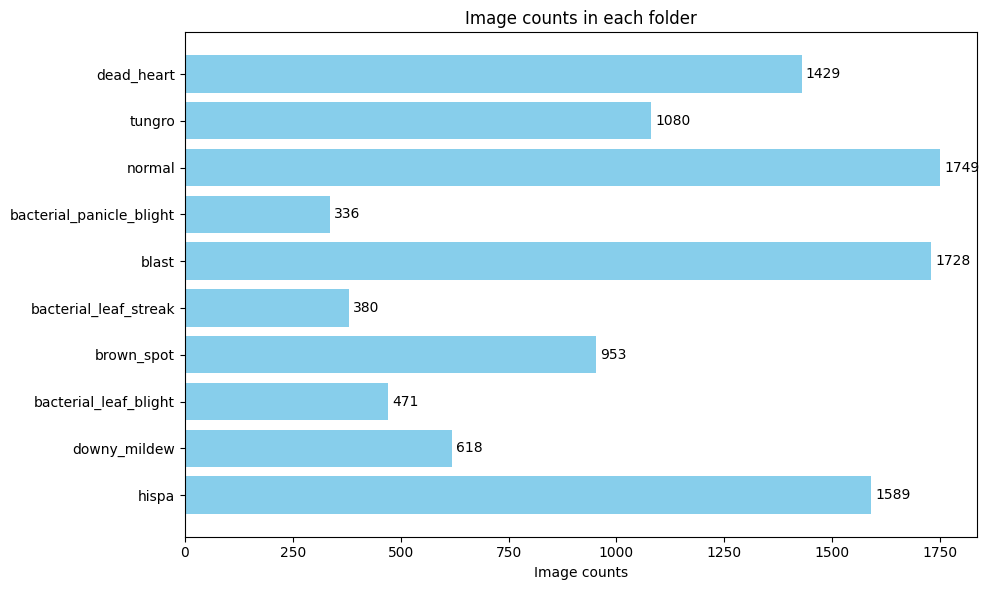

In [ ]:
dataset_path_task1_all = output_dir_task_1_all
print(f"Visualizing class distribution for Task 1 from: {dataset_path_task1_all}")

task1_data_counts = [] # List to store label and count for plotting
# Iterate through each item (expected to be label directories) in the Task 1 'all' dataset path
for label_dir_name in sorted(os.listdir(dataset_path_task1_all)): # Sorted for consistent plot order
    label_path = os.path.join(dataset_path_task1_all, label_dir_name)
    # Check if the item is a directory
    if os.path.isdir(label_path):
        # Count the number of image files in the label directory
        count = len([file for file in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, file)) and file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        task1_data_counts.append({"label": label_dir_name, "count": count})
        print(f"Category: {label_dir_name}, Image Count: {count}")

# Create a DataFrame from the collected counts for Task 1
df_counts_task1 = pd.DataFrame(task1_data_counts)

if not df_counts_task1.empty:
    # Sort by count for potentially better visualization, or keep alphabetical by label
    df_counts_task1 = df_counts_task1.sort_values(by='count', ascending=False)

    # Create the plot for Task 1
    plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
    bars = plt.barh(df_counts_task1['label'], df_counts_task1['count'], color='cornflowerblue')

    # Add text annotations for each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 5,  # Adjust x-position for text slightly to the right of the bar
                 bar.get_y() + bar.get_height()/2,
                 f'{width}', 
                 va='center', 
                 fontsize=9)

    plt.xlabel("Number of Images")
    plt.ylabel("Disease Label (Task 1)")
    plt.title("Distribution of Images per Disease Label (Task 1)")
    # plt.gca().invert_yaxis()  # Optional: Display the category with the highest count at the top
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()
else:
    print("No data to plot for Task 1 class distribution.")

## Task 1: Split Data into Training and Validation Sets

This cell applies a function `split_data_for_task` to divide the images within each disease label folder (located in `output_dir_task_1_all`) into separate training and validation sets. The split ratio is typically 80% for training and 20% for validation.

- **Purpose**: To create distinct datasets for training the model and for evaluating its performance on unseen data during development, which helps in tuning hyperparameters and preventing overfitting.
- **Why it Matters**: Separating data into training and validation sets is a cornerstone of robust machine learning model development. The model learns from the training set, and its ability to generalize to new, unseen data is assessed using the validation set. This helps in detecting overfitting and guiding model improvements.

In [ ]:
train_dir = f'/kaggle/working/output_images/Task_1/train'
val_dir = f'/kaggle/working/output_images/Task_1/val'

for category in os.listdir(output_dir_task_1):
    category_path = os.path.join(output_dir_task_1, category)
    if os.path.isdir(category_path):
        split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2)

dead_heart: 1143 train, 286 val
tungro: 864 train, 216 val
normal: 1399 train, 350 val
bacterial_panicle_blight: 268 train, 68 val
blast: 1382 train, 346 val
bacterial_leaf_streak: 304 train, 76 val
brown_spot: 762 train, 191 val
bacterial_leaf_blight: 376 train, 95 val
downy_mildew: 494 train, 124 val
hispa: 1271 train, 318 val


## Task 1: Zip Training and Validation Folders


In [33]:
def zip_two_folders(folder1, folder2, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Add folder1
        for root, dirs, files in os.walk(folder1):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder1))
                zipf.write(file_path, arcname)
        # Add folder2
        for root, dirs, files in os.walk(folder2):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder2))
                zipf.write(file_path, arcname)

    print(f"Zipped folders '{folder1}' and '{folder2}' into '{output_zip}'")


output_zip = '/kaggle/working/zip_output/task_1_data.zip'

zip_two_folders(train_dir, val_dir, output_zip)

Zipped folders '/kaggle/working/output_images/Task_1/train' and '/kaggle/working/output_images/Task_1/val' into '/kaggle/working/zip_output/task_1_data.zip'


# Task 2: Classification by Rice Variety

This section focuses on preparing the data for Task 2, which involves classifying rice leaf images based on the rice variety. The process mirrors Task 1 but uses the 'variety' column from the metadata for organization.
1.  Prepare an output directory structure for Task 2.
2.  Organize images from `standardize_dir` into subfolders named after their respective rice varieties.
3.  Visualize the class (variety) distribution.
4.  Split the organized data into training and validation sets.
5.  Zip the resulting training and validation folders.

## Task 2: Prepare Output Directory

In [4]:
MetaImagesDataframe = pd.read_csv('/kaggle/working/original_data/meta_train.csv')

standardize_dir = "/kaggle/working/standardized_images"
output_dir_task_2 = "/kaggle/working/output_images/Task_2"
full_dir_task_2 = "/kaggle/working/output_images/Task_2/full"
train_dir_task_2 = "/kaggle/working/output_images/Task_2/train"

# Extract the plants variety
variety_list =  set(MetaImagesDataframe['variety'])

In [ ]:
# Delete the folder if it exists
if os.path.exists(output_dir_task_2):
    shutil.rmtree(output_dir_task_2)

os.mkdir(output_dir_task_2)

## Task 2: Organize Images by Variety

This cell organizes images based on the 'variety' attribute from the `meta_train.csv` file. It creates subdirectories for each unique rice variety within `output_dir_task_2_all` and copies the corresponding images.

In [ ]:
# Create a folder of all images once inside output_dir_task_2
full_dir_task_2 = os.path.join(output_dir_task_2, 'full')
os.makedirs(full_dir_task_2, exist_ok=True)

# Create output directories for each category inside the folder
for category in variety_list:
    category_dir = os.path.join(full_dir_task_2, str(category))
    os.makedirs(category_dir, exist_ok=True)

# Copy images into the corresponding category folder
for _, row in MetaImagesDataframe.iterrows():
    image_name = row['image_id']  # Make sure this matches your column name
    category = row['variety']
    src_path = os.path.join(standardize_dir, image_name)
    dest_path = os.path.join(full_dir_task_2, str(category), image_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)

print("Images has been split by variety")

## Task 2: Visualize Class (Variety) Distribution
This cell calculates and visualizes the number of images per rice variety in the `output_dir_task_2_all` directory. This helps in understanding the balance or imbalance of varieties in the dataset prepared for Task 2.

{'ADT45', 'Zonal', 'Onthanel', 'Surya', 'AtchayaPonni', 'RR', 'IR20', 'KarnatakaPonni', 'Ponni', 'AndraPonni'}


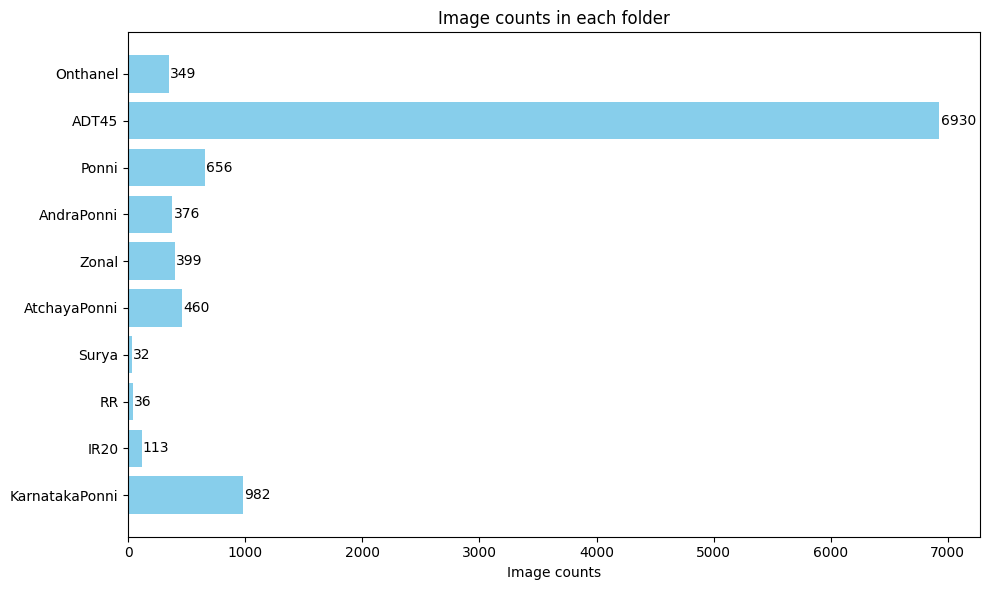

In [44]:
categories = variety_list
dataset_path = full_dir_task_2

print(categories)

data = []
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        count = len([file for file in os.listdir(label_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
        data.append({"label": label, "count": count})

df_counts = pd.DataFrame(data)

plt.figure(figsize=(10,6))
bars = plt.barh(df_counts['label'], df_counts['count'], color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             str(width), va='center', fontsize=10)

plt.xlabel("Image counts")
plt.title("Image counts in each folder")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Task 2: Split Data into Training and Validation Sets


In [15]:
train_dir = f'/kaggle/working/output_images/Task_2/train'
val_dir = f'/kaggle/working/output_images/Task_2/val'

for category in os.listdir(full_dir_task_2):
    category_path = os.path.join(full_dir_task_2, category)
    if os.path.isdir(category_path):
        split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2)

Onthanel: 279 train, 70 val
ADT45: 5544 train, 1386 val
Ponni: 524 train, 132 val
AndraPonni: 300 train, 76 val
Zonal: 319 train, 80 val
AtchayaPonni: 368 train, 92 val
Surya: 25 train, 7 val
RR: 28 train, 8 val
IR20: 90 train, 23 val
KarnatakaPonni: 785 train, 197 val


## Task 2: Under and Over Sampling the data
Undersampling: using TomekLinks
Oversampling: using SMOTE

In [16]:
# Prepare data structures
image_paths = []
labels = []

# Iterate through each class folder in the main directory
for label in os.listdir(train_dir_task_2):
    label_path = os.path.join(train_dir_task_2, label)
    
    # Ensure we're working with directories (class folders)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, img_name))  # Full image path
                labels.append(label)  # The folder name is the label

# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels_int = [label_map[label] for label in labels]  # Map labels to integers

# Create a DataFrame to hold the paths and labels
Task2TrainFrame = pd.DataFrame({
    'image_path': image_paths,
    'label': labels_int
})

# Check the first few rows of the dataframe
print(Task2TrainFrame.head())

                                          image_path  label
0  /kaggle/working/output_images/Task_2/train/Ont...      5
1  /kaggle/working/output_images/Task_2/train/Ont...      5
2  /kaggle/working/output_images/Task_2/train/Ont...      5
3  /kaggle/working/output_images/Task_2/train/Ont...      5
4  /kaggle/working/output_images/Task_2/train/Ont...      5


In [17]:
# Function to load and preprocess images (No normalization)
def load_images(image_paths):
    image_data = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert right away
            img = img.flatten()
            image_data.append(img)
    return np.array(image_data)


# Load images and convert to numerical feature matrix X
x_task_2 = load_images(Task2TrainFrame['image_path'])

# Labels vector
y_task_2 = np.array(Task2TrainFrame['label'])

# Check the shape of the feature matrix
print(x_task_2.shape)

(8262, 150528)


In [ ]:
# Step 1: Apply Tomek Links (Undersampling)
tomek = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek.fit_resample(x_task_2, y_task_2)
print(f"After Tomek Links: {Counter(y_tomek)}")

# Step 2: Compute average class size
unique, counts = np.unique(y_tomek, return_counts=True)
avg_count = int(np.mean(counts))
max_count = int(np.max(counts))

from math import log

sampling_strategy = {}
for label, count in zip(unique, counts):
    alpha = 4  # Increase this to push counts higher (try 1.1 to 1.5)
    if count < max_count:
        ratio = log(max_count + 1) / log(count + 1)
        target = int(count * ratio * alpha)
        sampling_strategy[label] = target
        print(f"Label {label}: from {count} ➜ {target} samples")
    # Majority class
    else:
        sampling_strategy[label] = count
        print(f"Label {label}: remains at {count} samples (majority class)")

# Step 4: Apply SMOTE (Oversampling)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_tomek, y_tomek)
print(f"After SMOTE: {Counter(y_balanced)}")

After Tomek Links: Counter({0: 5538, 4: 785, 6: 524, 2: 368, 9: 319, 1: 300, 5: 279, 3: 90, 7: 28, 8: 25})
Label 0: remains at 5538 samples (majority class)
Label 1: from 300 ➜ 1812 samples
Label 2: from 368 ➜ 2146 samples
Label 3: from 90 ➜ 687 samples
Label 4: from 785 ➜ 4059 samples
Label 5: from 279 ➜ 1707 samples
Label 6: from 524 ➜ 2884 samples
Label 7: from 28 ➜ 286 samples
Label 8: from 25 ➜ 264 samples
Label 9: from 319 ➜ 1906 samples
After SMOTE: Counter({0: 5538, 4: 4059, 6: 2884, 2: 2146, 9: 1906, 1: 1812, 5: 1707, 3: 687, 7: 286, 8: 264})


In [39]:
# === Step 1: Apply Tomek Links (undersample only majority class) ===
tomek = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek.fit_resample(x_task_2, y_task_2)
print("After Tomek Links:", Counter(y_tomek))

# === Step 2: Target class counts you want to reach ===
target_counts = {0: 5538, 4: 4059, 6: 2884, 2: 2146, 9: 1906,
                 1: 1812, 5: 1707, 3: 687, 7: 286, 8: 264}

# === Step 3: Duplicate (upsample) to match target counts ===
X_final = []
y_final = []

for label, target in target_counts.items():
    # Get all current samples of this class
    mask = y_tomek == label
    X_class = X_tomek[mask]
    y_class = y_tomek[mask]
    
    current_count = len(X_class)
    
    if current_count == 0:
        print(f"Warning: No samples for class {label} after Tomek Links.")
        continue

    if current_count >= target:
        # If already at or above target, truncate
        X_final.append(X_class[:target])
        y_final.append(y_class[:target])
    else:
        # Need to duplicate samples
        reps = target // current_count
        remainder = target % current_count

        # Repeat and then add some extra random samples
        X_upsampled = np.concatenate([X_class] * reps + [X_class[:remainder]])
        y_upsampled = np.array([label] * len(X_upsampled))

        X_final.append(X_upsampled)
        y_final.append(y_upsampled)

# === Step 4: Combine all classes ===
X_balanced = np.concatenate(X_final, axis=0)
y_balanced = np.concatenate(y_final, axis=0)

# Final check
print("Final distribution:", Counter(y_balanced))
print("X shape:", X_balanced.shape)

After Tomek Links: Counter({0: 5538, 4: 785, 6: 524, 2: 368, 9: 319, 1: 300, 5: 279, 3: 90, 7: 28, 8: 25})
Final distribution: Counter({0: 5538, 4: 4059, 6: 2884, 2: 2146, 9: 1906, 1: 1812, 5: 1707, 3: 687, 7: 286, 8: 264})
X shape: (21289, 150528)


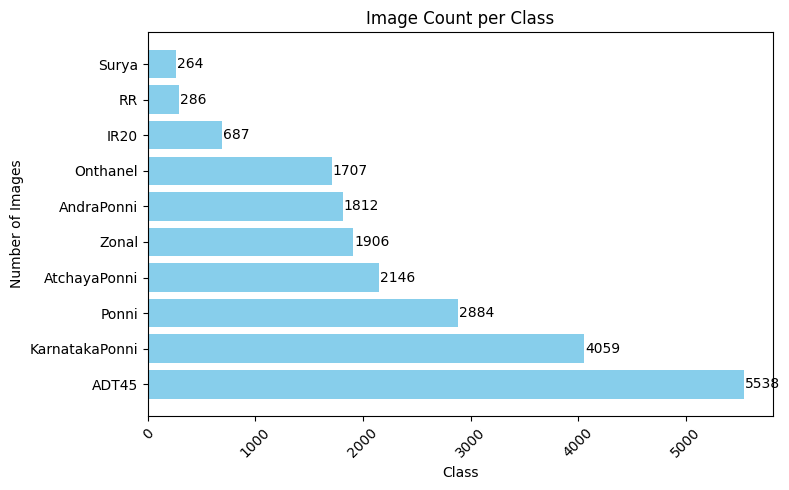

In [40]:
reverse_label_map = {v: k for k, v in label_map.items()}

# Example Counter object (after label encoding)
image_counts = Counter(y_balanced)

# Decode integer labels back to class names
class_names = [reverse_label_map[label] for label in image_counts.keys()]
counts = list(image_counts.values())

# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.barh(class_names, counts, color='skyblue')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             str(width), va='center', fontsize=10)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
reverse_label_map = {v: k for k, v in label_map.items()}

# Reset the current trainning folder
if os.path.exists(train_dir_task_2):
    shutil.rmtree(train_dir_task_2)
os.mkdir(train_dir_task_2)

# Replacing the folder with new images
for i in range(len(X_balanced)):
    cleaned_img = X_balanced[i].reshape(224, 224, 3).astype(np.uint8)
    cleaned_img_pil = Image.fromarray(cleaned_img)

    # Get class label name
    label_name = reverse_label_map[y_balanced[i]]

    # Create destination folder
    label_train_dir = os.path.join(train_dir_task_2, label_name)
    os.makedirs(label_train_dir, exist_ok=True)
    
    # Save image
    label_train_dir = os.path.join(train_dir_task_2, label_name)
    
    # Save image with a unique filename
    filename = f"task2_{i}.jpg"
    cleaned_img_pil.save(os.path.join(label_train_dir, filename))

## Task 2: Zip Training and Validation Folders

In [ ]:
# Define the output zip file name for Task 2 data
task_2_output_zip = zip_output_dir / "task_2_data.zip"

# Call the function to zip the Task 2 directory
# task_2_base_dir was defined as /kaggle/working/output_images/Task_2
if os.path.isdir(task_2_base_dir):
    zip_folder_contents(task_2_base_dir, task_2_output_zip)
else:
    print(f"Error: Task 2 base directory ({task_2_base_dir}) not found. Skipping zipping.")

# Task 3: Classification by Leaf Age

This section handles data preparation for Task 3: classifying rice leaf images by the age of the leaf. The structure follows that of Tasks 1 and 2, using the 'age' column from the metadata.
1.  Prepare an output directory structure for Task 3.
2.  Organize images from `standardize_dir` into subfolders named after their respective leaf ages.
3.  Visualize the class (age) distribution.
4.  Split the organized data into training and validation sets.
5.  Zip the resulting training and validation folders.

## Task 3: Prepare Output Directory


In [25]:
output_dir_task_3 = "/kaggle/working/output_images/Task_3/full"

In [26]:
# Delete the folder if it exists
if os.path.exists(output_dir_task_3):
    shutil.rmtree(output_dir_task_3)

os.mkdir(output_dir_task_3)

## Task 3: Organize Images by Leaf Age

This cell organizes images based on the 'age' attribute from `meta_train.csv`. It creates subdirectories for each unique leaf age within `output_dir_task_3_all` and copies the images accordingly.


In [27]:
# Create list to store image-age mappings
task3_data = []

# Copy images into the output folder and build mapping DataFrame
for _, row in MetaImagesDataframe.iterrows():
    image_name = row['image_id']
    age = row['age']
    
    src_path = os.path.join(standardize_dir, image_name)
    dest_path = os.path.join(output_dir_task_3, image_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
        task3_data.append({"image_id": image_name, "age": age})

# Create the mapping DataFrame
Task3AgeFrame = pd.DataFrame(task3_data)
print("Images copied to single folder for regression task. Task3AgeFrame created.")

Images copied to single folder for regression task. Task3AgeFrame created.


## Task 3: Visualize Class (Leaf Age) Distribution


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


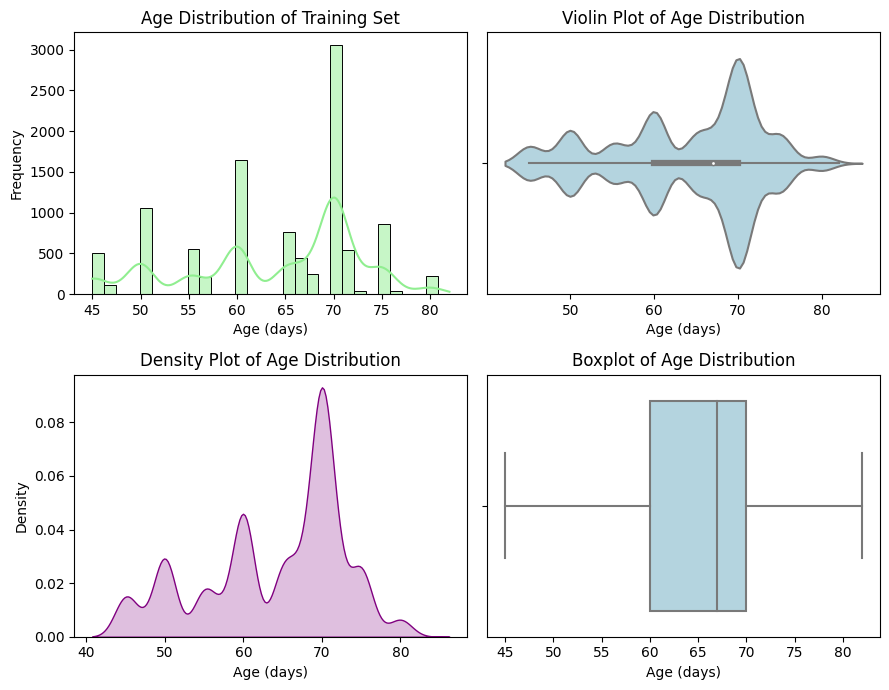

In [28]:
#Create a 2x2 grid of subplots for different visualizations of the age distribution
fig, axes = plt.subplots(2, 2, figsize=(9, 7))  # 2 rows, 2 columns of plots

# 1. Histogram with KDE (Kernel Density Estimate) overlay
# Shows the frequency distribution of ages with a smoothed density curve
sns.histplot(
    Task3AgeFrame['age'],
    bins=30,                # Number of bins (bars)
    kde=True,               # Add density curve
    color='lightgreen',     # Bar color
    edgecolor='black',      # Bar outline color
    ax=axes[0, 0]           # Place in top-left position
)
axes[0, 0].set_title("Age Distribution of Training Set")
axes[0, 0].set_xlabel("Age (days)")
axes[0, 0].set_ylabel("Frequency")

# 2. Violin plot
# Shows distribution shape, with width indicating density at each age value
sns.violinplot(
    x=Task3AgeFrame['age'],
    color='lightblue',
    ax=axes[0, 1]           # Place in top-right position
)
axes[0, 1].set_title("Violin Plot of Age Distribution")
axes[0, 1].set_xlabel("Age (days)")

# 3. Density plot (KDE)
# Shows the probability density function of the age distribution
sns.kdeplot(
    Task3AgeFrame['age'],
    fill=True,              # Fill area under the curve
    color='purple',
    ax=axes[1, 0]           # Place in bottom-left position
)
axes[1, 0].set_title("Density Plot of Age Distribution")
axes[1, 0].set_xlabel("Age (days)")
axes[1, 0].set_ylabel("Density")

# 4. Boxplot
# Shows median, quartiles, and potential outliers
sns.boxplot(
    x=Task3AgeFrame['age'],
    color='lightblue',
    ax=axes[1, 1]           # Place in bottom-right position
)
axes[1, 1].set_title("Boxplot of Age Distribution")
axes[1, 1].set_xlabel("Age (days)")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()  # Display all plots

Age distributions are heavily skewed with missing data, very hard to apply any normal samping techniques

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


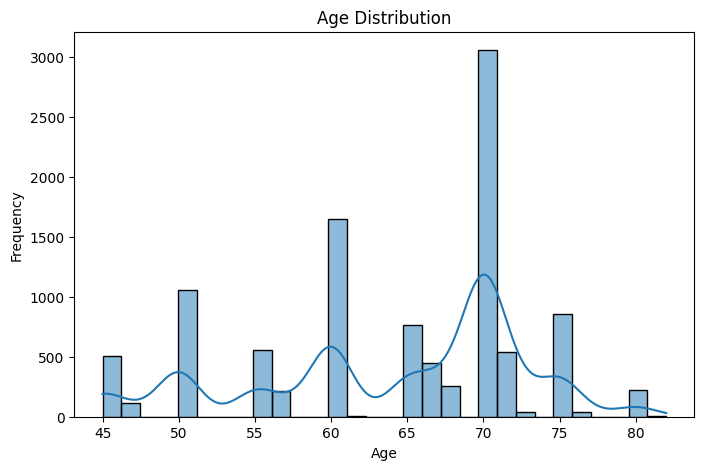

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your labels are in a variable called `ages`
plt.figure(figsize=(8, 5))
sns.histplot(Task3AgeFrame['age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import skew  # More reliable for skewness

ages = Task3AgeFrame['age']  # Use Series instead of DataFrame with double brackets

print("Basic Age Statistics:")
print(f"Mean: {ages.mean():.2f}")
print(f"Std: {ages.std():.2f}")
print(f"Min: {ages.min()}")
print(f"Max: {ages.max()}")
print(f"Skew: {skew(ages):.2f}")  # Now using scipy.stats.skew

Basic Age Statistics:
Mean: 64.04
Std: 8.96
Min: 45
Max: 82
Skew: -0.59


## Task 3: Split Data into Training and Validation Sets


In [ ]:
train_dir = f'/kaggle/working/output_images/Task_3/train'
val_dir = f'/kaggle/working/output_images/Task_3/val'

split_train_val_with_sklearn(full_dir_task_3, train_dir, val_dir, test_size=0.2)

full: 8266 train, 2067 val


## Task 3: Zip Training and Validation Folders


In [32]:
# Replace with your actual folder and output zip path
folder_to_zip = '/kaggle/working/output_images/Task_3/full'
output_zip = 'zip_output/task_3_data.zip'

shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_to_zip)

'/kaggle/working/zip_output/task_3_data.zip'

## Save Processed Metadata

In [31]:
# Save to CSV
csv_path = '/kaggle/working/output_images/Task_3/task_3_metadata.csv'
Task3AgeFrame.to_csv(csv_path, index=False)

print(f"DataFrame saved to {csv_path}")

DataFrame saved to /kaggle/working/output_images/Task_3/task_3_metadata.csv


## Conclusion

This notebook has performed the following key steps:
1.  **Environment Setup**: Installed necessary libraries with specific versions.
2.  **Data Acquisition**: Downloaded the main image dataset and its metadata.
3.  **Data Cleaning**: Checked for missing metadata and removed duplicate/corrupted images from a consolidated image folder.
4.  **Data Preprocessing**: Standardized all images (resize, convert to RGB, normalize, blur).
5.  **Task-Specific Preparation (Tasks 1, 2, and 3)**:
    a.  Created dedicated output directories.
    b.  Organized images into subfolders based on task-specific criteria (disease label, rice variety, leaf age).
    c.  Visualized class distributions for each task.
    d.  Split the data into training (80%) and validation (20%) sets for each task.
    e.  Zipped the final `train` and `val` folders for each task into `task_1_data.zip`, `task_2_data.zip`, and `task_3_data.zip` respectively, located in the `/kaggle/working/zip_output/` directory.
6.  **Metadata Saving**: Optionally saved the processed metadata.

The resulting zip files contain the prepared datasets ready for model training for each of the three classification tasks.